# KoT5-Smal Train - 8K
- GKSL 8K
- 모듈에서 불러오는 모델 적용

https://github.com/paust-team/pko-t5

## 0. 라이브러리 및 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import torch.optim as optim

In [2]:
# meteor_score 
import nltk

nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/stonemaeng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/stonemaeng/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device('cpu')

In [5]:
from transformers import T5ForConditionalGeneration, T5TokenizerFast

# KoT5 모델과 토크나이저 로드
model_name = 'paust/pko-t5-small'

tokenizer = T5TokenizerFast.from_pretrained(model_name, force_download=True)
model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)

tokenizer_config.json:   0%|          | 0.00/1.95k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.95k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/383M [00:00<?, ?B/s]

In [6]:
# 텍스트를 토큰화하여 입력 ID로 변환
sentence = "가장 가까운 위치로 검색해드리겠습니다"
encoded = tokenizer(sentence)
input_ids = encoded["input_ids"]
print(input_ids)

[985, 222, 3350, 222, 1293, 293, 222, 1759, 322, 2793, 1]


In [7]:
# 만약 개별 토큰을 보고 싶다면, 이 경우에는 바이트로 처리되기 때문에 결과가 깨질 수 있음
tokens = tokenizer.convert_ids_to_tokens(input_ids)
print("Tokens:", tokens)

Tokens: ['ê°Ģìŀ¥', 'Ġ', 'ê°Ģê¹Įìļ´', 'Ġ', 'ìľĦì¹ĺ', 'ë¡ľ', 'Ġ', 'ê²Ģìĥī', 'íķ´', 'ëĵľë¦¬ê²łìĬµëĭĪëĭ¤', '</s>']


In [8]:
# 각 ID를 디코딩하여 개별 토큰이 어떤 텍스트를 나타내는지 확인
individual_decoded_tokens = [tokenizer.decode([id]) for id in input_ids]
print("Individual Decoded Tokens:", individual_decoded_tokens)

Individual Decoded Tokens: ['가장', ' ', '가까운', ' ', '위치', '로', ' ', '검색', '해', '드리겠습니다', '</s>']


In [9]:
tokenizer.decode(encoded['input_ids'], skip_special_tokens=True)

'가장 가까운 위치로 검색해드리겠습니다'

**한글깨짐 문제 **

- 한글이 깨지는 것이 아니라, Byte-level BPE를 사용하여 text를 byte의 sequence로 처리하기에 다음과 같은 토큰들의 결과가 나오는 것
- 해당 출력 토큰의 'input_ids' 값을 tokenizer.decode(string) 하면 해당 결과를 확인

In [9]:
model.config

T5Config {
  "_name_or_path": "paust/pko-t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "tie_word_embeddings": false,
  "torch_dtype": "float32",
  "transformers_version": "4.38.2",
  "use_cache": true,
  "vocab_size": 50358
}

In [10]:
model

T5ForConditionalGeneration(
  (shared): Embedding(50358, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(50358, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

### 데이터 불러오기

In [10]:
df = pd.read_csv('https://raw.githubusercontent.com/AIRC-KETI/GKSL-dataset/main/dataset/GKSL13k_augmented.csv')
df.columns = ['augmentation_method', 'idx', 'gloss', 'text']
df.head(30)

,augmentation_method,idx,gloss,text
0,SR,1,집 불,댁에 불이 났어요.
1,SR,2,집 불,주택에 불이 났어요.
2,SR,3,집 불,가옥에 불이 났어요.
3,SR,4,집 불,세대에 불이 났어요.
4,SR,5,도착 10분 전,10분 내로 당도합니다.
5,SR,6,도착 10분,10분 뒤에 당도합니다.
6,SR,7,도착 1시간 전,1시간 내로 당도합니다.
7,SR,8,도착 1시,1시에 당도합니다.
8,SR,9,1호 갈아타다 목적 곳곳,1호선 환승하는 위치는 어디인가요?
9,SR,10,1호 갈아타다 목적 곳곳,1호선 환승하는 장소는 어디인가요?


In [11]:
df[~df['text'].str.contains('\?')]

<>:1: SyntaxWarning: invalid escape sequence '\?'
<>:1: SyntaxWarning: invalid escape sequence '\?'
/tmp/ipykernel_49846/839258348.py:1: SyntaxWarning: invalid escape sequence '\?'
  df[~df['text'].str.contains('\?')]


,augmentation_method,idx,gloss,text
0,SR,1,집 불,댁에 불이 났어요.
1,SR,2,집 불,주택에 불이 났어요.
2,SR,3,집 불,가옥에 불이 났어요.
3,SR,4,집 불,세대에 불이 났어요.
4,SR,5,도착 10분 전,10분 내로 당도합니다.
...,...,...,...,...
13041,BR,10649,할아버지 밤 4 매일 일어나다,할아버지는 매일 밤 4시에 일어나신다
13042,BR,10650,배우다 곳 다니다,학원에 다니다
13044,BR,10652,중 사이 곳 내리다 맞다,중간정류장에서 내려주세요.
13045,BR,10653,무덤 장소 곳 가다,묘지로 가주세요.


## 1. 데이터 파악

In [12]:
len(df), len(df.gloss.unique()), len(df.text.unique())

(13047, 11345, 8451)

In [13]:
for i in df.augmentation_method.unique():
  print(i, ':', len(df[df.augmentation_method==i]))

SR : 899
SP : 1494
BR : 10654


In [14]:
# '?'가 포함된 행 제거
print(len(df[~df['text'].str.contains('\?')])/len(df)) # 절반 이상 날라감
df[~df['text'].str.contains('\?')].head(10)

0.6439028129071818


<>:2: SyntaxWarning: invalid escape sequence '\?'
<>:3: SyntaxWarning: invalid escape sequence '\?'
<>:2: SyntaxWarning: invalid escape sequence '\?'
<>:3: SyntaxWarning: invalid escape sequence '\?'
/tmp/ipykernel_49846/1118718847.py:2: SyntaxWarning: invalid escape sequence '\?'
  print(len(df[~df['text'].str.contains('\?')])/len(df)) # 절반 이상 날라감
/tmp/ipykernel_49846/1118718847.py:3: SyntaxWarning: invalid escape sequence '\?'
  df[~df['text'].str.contains('\?')].head(10)


,augmentation_method,idx,gloss,text
0,SR,1,집 불,댁에 불이 났어요.
1,SR,2,집 불,주택에 불이 났어요.
2,SR,3,집 불,가옥에 불이 났어요.
3,SR,4,집 불,세대에 불이 났어요.
4,SR,5,도착 10분 전,10분 내로 당도합니다.
5,SR,6,도착 10분,10분 뒤에 당도합니다.
6,SR,7,도착 1시간 전,1시간 내로 당도합니다.
7,SR,8,도착 1시,1시에 당도합니다.
12,SR,13,2016 새롭다 날 시작,"2016년, 새해가 출발한다"
13,SR,14,도착 3시,3시에 당도합니다.


### 데이터 전처리

In [15]:
df = df[~df['text'].str.contains('\?')]
df = df[['gloss', 'text']]
df.head(30)

<>:1: SyntaxWarning: invalid escape sequence '\?'
<>:1: SyntaxWarning: invalid escape sequence '\?'
/tmp/ipykernel_49846/123297376.py:1: SyntaxWarning: invalid escape sequence '\?'
  df = df[~df['text'].str.contains('\?')]


,gloss,text
0,집 불,댁에 불이 났어요.
1,집 불,주택에 불이 났어요.
2,집 불,가옥에 불이 났어요.
3,집 불,세대에 불이 났어요.
4,도착 10분 전,10분 내로 당도합니다.
5,도착 10분,10분 뒤에 당도합니다.
6,도착 1시간 전,1시간 내로 당도합니다.
7,도착 1시,1시에 당도합니다.
12,2016 새롭다 날 시작,"2016년, 새해가 출발한다"
13,도착 3시,3시에 당도합니다.


### 문장 길이 시각화
max_len 설정을 위함

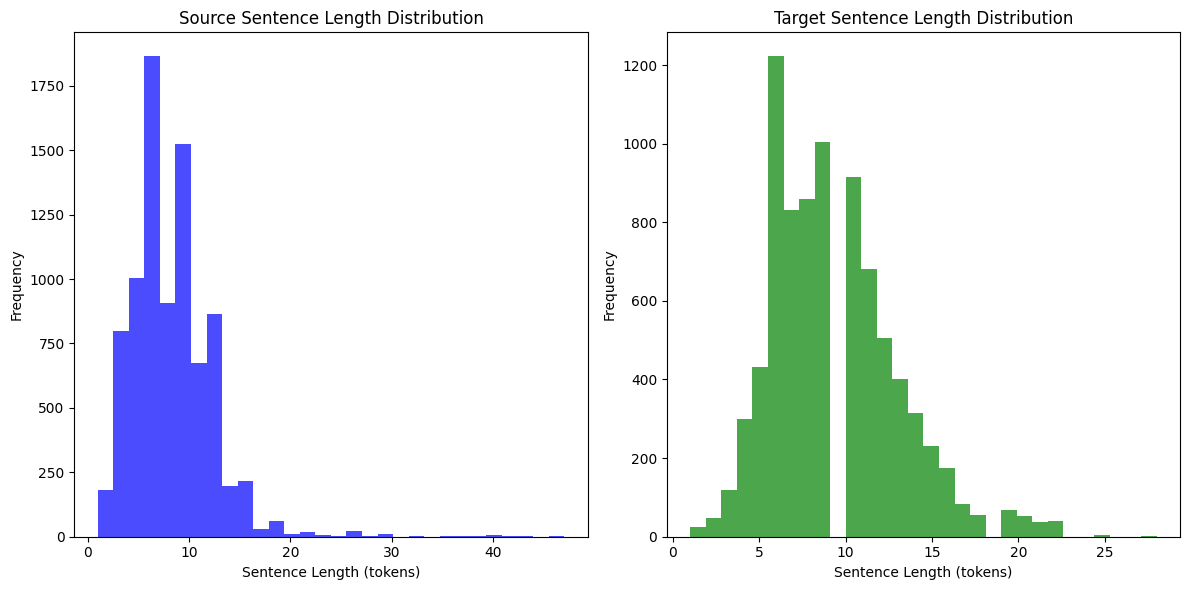

In [16]:
import matplotlib.pyplot as plt

# 각 문장의 토큰 길이를 KoBART 토크나이저로 계산 -> 서브워드 단어로 더 잘게 쪼개줌
df['source_len'] = df['gloss'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False)))
df['target_len'] = df['text'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False)))

# 히스토그램을 그려서 분포 확인
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(df['source_len'], bins=30, color='blue', alpha=0.7)
plt.title('Source Sentence Length Distribution')
plt.xlabel('Sentence Length (tokens)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['target_len'], bins=30, color='green', alpha=0.7)
plt.title('Target Sentence Length Distribution')
plt.xlabel('Sentence Length (tokens)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [17]:
# 문장 길이 통계
source_stats = df['source_len'].describe(percentiles=[.25, .5, .75, .9, .95, .99])
target_stats = df['target_len'].describe(percentiles=[.25, .5, .75, .9, .95, .99])

print("Source Sentence Length Stats:\n", source_stats)
print("\nTarget Sentence Length Stats:\n", target_stats)

Source Sentence Length Stats:
 count    8401.000000
mean        8.338650
std         3.941379
min         1.000000
25%         6.000000
50%         8.000000
75%        11.000000
90%        13.000000
95%        14.000000
99%        20.000000
max        47.000000
Name: source_len, dtype: float64

Target Sentence Length Stats:
 count    8401.000000
mean        9.284847
std         3.664686
min         1.000000
25%         6.000000
50%         9.000000
75%        11.000000
90%        14.000000
95%        16.000000
99%        20.000000
max        28.000000
Name: target_len, dtype: float64


## 2. 데이터 로더 생성

In [18]:
from torch.utils.data import Dataset, DataLoader

class GlossDataset(Dataset):
    def __init__(self, glosses, texts, tokenizer, max_length=16):
        self.glosses = glosses
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.glosses)

    def __getitem__(self, idx):
        gloss = self.glosses[idx]
        text = self.texts[idx]

        # 입력(글로스) 토큰화
        inputs = self.tokenizer(gloss, return_tensors="pt", max_length=self.max_length, padding="max_length", truncation=True)

        # 출력(텍스트) 토큰화
        labels = self.tokenizer(text, return_tensors="pt", max_length=self.max_length, padding="max_length", truncation=True)

        input_ids = inputs.input_ids.squeeze()
        attention_mask = inputs.attention_mask.squeeze()
        labels = labels.input_ids.squeeze()

        return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

In [19]:
from sklearn.model_selection import train_test_split

# 데이터셋 분할
train_glosses, val_glosses, train_texts, val_texts = train_test_split(df['gloss'].tolist(), df['text'].tolist(), test_size=0.2, random_state=42)
val_glosses, test_glosses, val_texts, test_texts = train_test_split(val_glosses, val_texts, test_size=0.5, random_state=42)

# 데이터셋 생성
train_dataset = GlossDataset(glosses=train_glosses, texts=train_texts, tokenizer=tokenizer)
val_dataset = GlossDataset(glosses=val_glosses, texts=val_texts, tokenizer=tokenizer)
test_dataset = GlossDataset(glosses=test_glosses, texts=test_texts, tokenizer=tokenizer)

# 데이터로더 생성
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [20]:
train_dataset[0]

{'input_ids': tensor([3074,  222, 6459, 2892,  267,  222, 1363,    1,    0,    0,    0,    0,
            0,    0,    0,    0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor([ 3074,   291,   222,  6459, 11992,    15,     1,     0,     0,     0,
             0,     0,     0,     0,     0,     0])}

## 3. 모델 준비

In [21]:
import torch
from transformers import AdamW, get_linear_schedule_with_warmup

# 옵티마이저와 손실 함수 설정
optimizer = AdamW(model.parameters(), lr=2e-5)  # 학습률은 실험적으로 조정할 수 있음 1e-4, 1e-5
loss_fn = torch.nn.CrossEntropyLoss()

# 학습률 스케줄러 설정
num_epochs = 100

total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

/home/stonemaeng/anaconda3/envs/g2t/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## 4. KoT5 학습


In [22]:
# 체크포인트를 저장할 디렉토리 설정
import os

checkpoint_dir = './checkpoints_0822_small'
os.makedirs(checkpoint_dir, exist_ok=True)

In [23]:
import tqdm
from tqdm import tqdm
import sacrebleu
from nltk.translate.meteor_score import meteor_score

# 손실 값을 저장할 리스트 초기화
train_losses = []
val_losses = []
bleu_scores = []
meteor_scores = []

# 조기 종료 변수 설정
best_val_loss = float('inf')
epochs_since_improvement = 0

for epoch in range(num_epochs):
    model.train()  # 학습 모드로 전환
    total_loss = 0

    print(f'\nStarting epoch {epoch+1}/{num_epochs}')

    # tqdm을 사용하여 배치 진행 상태 표시
    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
        optimizer.zero_grad()  # 기울기 초기화

        # 입력 데이터를 GPU로 이동
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # 모델에 데이터 전달
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()  # 역전파
        optimizer.step()  # 옵티마이저 스텝
        scheduler.step()  # 학습률 스케줄러 스텝

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_loss)  # 훈련 손실 저장

    # Epoch 종료 후 검증 데이터셋에서 성능 평가
    model.eval()  # 평가 모드로 전환
    total_val_loss = 0
    predictions = []
    references = []

    with torch.no_grad():
        # tqdm을 사용하여 검증 배치 진행 상태 표시
        for batch in tqdm(val_dataloader, desc='Validation', unit='batch'):
            # 입력 데이터를 GPU로 이동
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

            # 예측 결과 디코딩
            decoded_preds = tokenizer.batch_decode(outputs.logits.argmax(dim=-1), skip_special_tokens=True)

            # 실제 레이블 디코딩
            decoded_labels = []
            for label in labels:
                label_ids = label[label != tokenizer.pad_token_id].tolist()
                decoded_label = tokenizer.decode(label_ids, skip_special_tokens=True)
                decoded_labels.append(decoded_label)

            # 예측 결과와 참조 번역 수집
            predictions.extend(decoded_preds)
            references.extend(decoded_labels)

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)  # 검증 손실 저장

    # BLEU 점수 계산
    bleu_score_value = sacrebleu.corpus_bleu(predictions, [references])
    bleu_scores.append(bleu_score_value.score)

    # METEOR 점수 계산 (참조 및 예측을 토큰화하여 전달)
    meteor_score_value = np.mean([meteor_score([ref.split()], pred.split()) for ref, pred in zip(references, predictions)])
    meteor_scores.append(meteor_score_value)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, BLEU: {bleu_score_value.score:.4f}, METEOR: {meteor_score_value:.4f}')

    # 체크포인트 저장
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pt')
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': avg_loss,
        'val_loss': avg_val_loss,
        'bleu_score': bleu_score_value.score,
        'meteor_score': meteor_score_value
    }, checkpoint_path)

    print(f'Checkpoint saved to {checkpoint_path}')



Starting epoch 1/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 73.03batch/s]


Epoch 1/100, Loss: 1.9395, Validation Loss: 1.0169, BLEU: 8.1117, METEOR: 0.2106
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_1.pt

Starting epoch 2/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 73.85batch/s]


Epoch 2/100, Loss: 1.0186, Validation Loss: 0.7773, BLEU: 15.6839, METEOR: 0.3053
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_2.pt

Starting epoch 3/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 72.39batch/s]


Epoch 3/100, Loss: 0.8135, Validation Loss: 0.6341, BLEU: 27.3884, METEOR: 0.3933
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_3.pt

Starting epoch 4/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 72.47batch/s]


Epoch 4/100, Loss: 0.6728, Validation Loss: 0.5379, BLEU: 36.6986, METEOR: 0.4542
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_4.pt

Starting epoch 5/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 74.89batch/s]


Epoch 5/100, Loss: 0.5651, Validation Loss: 0.4720, BLEU: 43.7433, METEOR: 0.5069
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_5.pt

Starting epoch 6/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 72.56batch/s]


Epoch 6/100, Loss: 0.4899, Validation Loss: 0.4239, BLEU: 49.3068, METEOR: 0.5497
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_6.pt

Starting epoch 7/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 73.80batch/s]


Epoch 7/100, Loss: 0.4288, Validation Loss: 0.3884, BLEU: 53.7147, METEOR: 0.5855
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_7.pt

Starting epoch 8/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 73.50batch/s]


Epoch 8/100, Loss: 0.3784, Validation Loss: 0.3610, BLEU: 56.6192, METEOR: 0.6115
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_8.pt

Starting epoch 9/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 74.78batch/s]


Epoch 9/100, Loss: 0.3395, Validation Loss: 0.3404, BLEU: 59.2881, METEOR: 0.6327
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_9.pt

Starting epoch 10/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 73.55batch/s]


Epoch 10/100, Loss: 0.3083, Validation Loss: 0.3230, BLEU: 60.7116, METEOR: 0.6504
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_10.pt

Starting epoch 11/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 73.64batch/s]


Epoch 11/100, Loss: 0.2784, Validation Loss: 0.3108, BLEU: 62.5980, METEOR: 0.6661
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_11.pt

Starting epoch 12/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 72.99batch/s]


Epoch 12/100, Loss: 0.2538, Validation Loss: 0.3013, BLEU: 64.4626, METEOR: 0.6832
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_12.pt

Starting epoch 13/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 69.41batch/s]


Epoch 13/100, Loss: 0.2321, Validation Loss: 0.2917, BLEU: 65.4232, METEOR: 0.6909
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_13.pt

Starting epoch 14/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 72.30batch/s]


Epoch 14/100, Loss: 0.2145, Validation Loss: 0.2856, BLEU: 66.2120, METEOR: 0.6943
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_14.pt

Starting epoch 15/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 75.13batch/s]


Epoch 15/100, Loss: 0.1990, Validation Loss: 0.2792, BLEU: 67.8703, METEOR: 0.7098
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_15.pt

Starting epoch 16/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 74.53batch/s]


Epoch 16/100, Loss: 0.1849, Validation Loss: 0.2745, BLEU: 68.1577, METEOR: 0.7142
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_16.pt

Starting epoch 17/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 74.72batch/s]


Epoch 17/100, Loss: 0.1717, Validation Loss: 0.2708, BLEU: 69.6170, METEOR: 0.7241
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_17.pt

Starting epoch 18/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 74.02batch/s]


Epoch 18/100, Loss: 0.1613, Validation Loss: 0.2673, BLEU: 70.3739, METEOR: 0.7274
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_18.pt

Starting epoch 19/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 72.75batch/s]


Epoch 19/100, Loss: 0.1499, Validation Loss: 0.2644, BLEU: 71.2578, METEOR: 0.7365
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_19.pt

Starting epoch 20/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 74.09batch/s]


Epoch 20/100, Loss: 0.1434, Validation Loss: 0.2624, BLEU: 71.3273, METEOR: 0.7380
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_20.pt

Starting epoch 21/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 74.65batch/s]


Epoch 21/100, Loss: 0.1342, Validation Loss: 0.2618, BLEU: 71.6400, METEOR: 0.7381
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_21.pt

Starting epoch 22/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 74.17batch/s]


Epoch 22/100, Loss: 0.1262, Validation Loss: 0.2580, BLEU: 72.0371, METEOR: 0.7427
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_22.pt

Starting epoch 23/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 73.87batch/s]


Epoch 23/100, Loss: 0.1194, Validation Loss: 0.2566, BLEU: 72.7667, METEOR: 0.7522
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_23.pt

Starting epoch 24/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 75.13batch/s]


Epoch 24/100, Loss: 0.1134, Validation Loss: 0.2557, BLEU: 73.2174, METEOR: 0.7536
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_24.pt

Starting epoch 25/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 75.00batch/s]


Epoch 25/100, Loss: 0.1068, Validation Loss: 0.2551, BLEU: 73.3422, METEOR: 0.7527
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_25.pt

Starting epoch 26/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 75.22batch/s]


Epoch 26/100, Loss: 0.1031, Validation Loss: 0.2541, BLEU: 73.3986, METEOR: 0.7543
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_26.pt

Starting epoch 27/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 74.60batch/s]


Epoch 27/100, Loss: 0.0979, Validation Loss: 0.2551, BLEU: 73.3280, METEOR: 0.7554
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_27.pt

Starting epoch 28/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 75.56batch/s]


Epoch 28/100, Loss: 0.0920, Validation Loss: 0.2551, BLEU: 73.5209, METEOR: 0.7554
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_28.pt

Starting epoch 29/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 82.94batch/s]


Epoch 29/100, Loss: 0.0881, Validation Loss: 0.2554, BLEU: 73.7274, METEOR: 0.7549
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_29.pt

Starting epoch 30/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 83.92batch/s]


Epoch 30/100, Loss: 0.0852, Validation Loss: 0.2540, BLEU: 73.9928, METEOR: 0.7594
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_30.pt

Starting epoch 31/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 83.13batch/s]


Epoch 31/100, Loss: 0.0822, Validation Loss: 0.2564, BLEU: 74.2350, METEOR: 0.7607
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_31.pt

Starting epoch 32/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 82.81batch/s]


Epoch 32/100, Loss: 0.0796, Validation Loss: 0.2565, BLEU: 74.4051, METEOR: 0.7647
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_32.pt

Starting epoch 33/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 83.67batch/s]


Epoch 33/100, Loss: 0.0764, Validation Loss: 0.2559, BLEU: 74.1437, METEOR: 0.7611
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_33.pt

Starting epoch 34/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 82.93batch/s]


Epoch 34/100, Loss: 0.0718, Validation Loss: 0.2561, BLEU: 74.4782, METEOR: 0.7621
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_34.pt

Starting epoch 35/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 83.48batch/s]


Epoch 35/100, Loss: 0.0690, Validation Loss: 0.2584, BLEU: 74.2762, METEOR: 0.7628
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_35.pt

Starting epoch 36/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 83.48batch/s]


Epoch 36/100, Loss: 0.0682, Validation Loss: 0.2602, BLEU: 74.4183, METEOR: 0.7631
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_36.pt

Starting epoch 37/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 83.01batch/s]


Epoch 37/100, Loss: 0.0651, Validation Loss: 0.2607, BLEU: 74.4626, METEOR: 0.7648
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_37.pt

Starting epoch 38/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 82.70batch/s]


Epoch 38/100, Loss: 0.0625, Validation Loss: 0.2597, BLEU: 74.2134, METEOR: 0.7625
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_38.pt

Starting epoch 39/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 83.53batch/s]


Epoch 39/100, Loss: 0.0605, Validation Loss: 0.2593, BLEU: 74.8951, METEOR: 0.7644
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_39.pt

Starting epoch 40/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 82.99batch/s]


Epoch 40/100, Loss: 0.0587, Validation Loss: 0.2618, BLEU: 74.7497, METEOR: 0.7665
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_40.pt

Starting epoch 41/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 82.20batch/s]


Epoch 41/100, Loss: 0.0577, Validation Loss: 0.2619, BLEU: 75.0158, METEOR: 0.7669
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_41.pt

Starting epoch 42/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 83.39batch/s]


Epoch 42/100, Loss: 0.0549, Validation Loss: 0.2635, BLEU: 74.8511, METEOR: 0.7643
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_42.pt

Starting epoch 43/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 83.12batch/s]


Epoch 43/100, Loss: 0.0543, Validation Loss: 0.2626, BLEU: 74.8070, METEOR: 0.7644
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_43.pt

Starting epoch 44/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 83.61batch/s]


Epoch 44/100, Loss: 0.0518, Validation Loss: 0.2626, BLEU: 74.8376, METEOR: 0.7646
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_44.pt

Starting epoch 45/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 83.41batch/s]


Epoch 45/100, Loss: 0.0519, Validation Loss: 0.2644, BLEU: 74.9088, METEOR: 0.7667
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_45.pt

Starting epoch 46/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 83.37batch/s]


Epoch 46/100, Loss: 0.0505, Validation Loss: 0.2645, BLEU: 75.0083, METEOR: 0.7688
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_46.pt

Starting epoch 47/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 82.41batch/s]


Epoch 47/100, Loss: 0.0495, Validation Loss: 0.2662, BLEU: 75.1079, METEOR: 0.7695
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_47.pt

Starting epoch 48/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 82.80batch/s]


Epoch 48/100, Loss: 0.0480, Validation Loss: 0.2664, BLEU: 74.8424, METEOR: 0.7675
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_48.pt

Starting epoch 49/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 83.13batch/s]


Epoch 49/100, Loss: 0.0458, Validation Loss: 0.2675, BLEU: 74.8097, METEOR: 0.7666
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_49.pt

Starting epoch 50/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 83.15batch/s]


Epoch 50/100, Loss: 0.0457, Validation Loss: 0.2680, BLEU: 75.0562, METEOR: 0.7689
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_50.pt

Starting epoch 51/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 81.82batch/s]


Epoch 51/100, Loss: 0.0447, Validation Loss: 0.2688, BLEU: 74.5519, METEOR: 0.7641
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_51.pt

Starting epoch 52/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 83.24batch/s]


Epoch 52/100, Loss: 0.0442, Validation Loss: 0.2704, BLEU: 74.8460, METEOR: 0.7659
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_52.pt

Starting epoch 53/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 82.93batch/s]


Epoch 53/100, Loss: 0.0430, Validation Loss: 0.2700, BLEU: 75.0263, METEOR: 0.7681
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_53.pt

Starting epoch 54/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 83.91batch/s]


Epoch 54/100, Loss: 0.0422, Validation Loss: 0.2706, BLEU: 74.8298, METEOR: 0.7656
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_54.pt

Starting epoch 55/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 83.76batch/s]


Epoch 55/100, Loss: 0.0417, Validation Loss: 0.2697, BLEU: 75.4227, METEOR: 0.7720
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_55.pt

Starting epoch 56/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 83.41batch/s]


Epoch 56/100, Loss: 0.0411, Validation Loss: 0.2699, BLEU: 75.4044, METEOR: 0.7699
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_56.pt

Starting epoch 57/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 83.06batch/s]


Epoch 57/100, Loss: 0.0408, Validation Loss: 0.2708, BLEU: 75.4218, METEOR: 0.7719
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_57.pt

Starting epoch 58/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 82.15batch/s]


Epoch 58/100, Loss: 0.0398, Validation Loss: 0.2707, BLEU: 75.1118, METEOR: 0.7696
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_58.pt

Starting epoch 59/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 83.57batch/s]


Epoch 59/100, Loss: 0.0391, Validation Loss: 0.2711, BLEU: 75.3057, METEOR: 0.7715
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_59.pt

Starting epoch 60/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 82.91batch/s]


Epoch 60/100, Loss: 0.0381, Validation Loss: 0.2718, BLEU: 75.5387, METEOR: 0.7712
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_60.pt

Starting epoch 61/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 82.09batch/s]


Epoch 61/100, Loss: 0.0376, Validation Loss: 0.2730, BLEU: 75.3623, METEOR: 0.7686
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_61.pt

Starting epoch 62/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 83.58batch/s]


Epoch 62/100, Loss: 0.0375, Validation Loss: 0.2742, BLEU: 75.2283, METEOR: 0.7684
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_62.pt

Starting epoch 63/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 83.24batch/s]


Epoch 63/100, Loss: 0.0359, Validation Loss: 0.2754, BLEU: 74.9577, METEOR: 0.7667
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_63.pt

Starting epoch 64/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 83.18batch/s]


Epoch 64/100, Loss: 0.0368, Validation Loss: 0.2753, BLEU: 74.9447, METEOR: 0.7671
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_64.pt

Starting epoch 65/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 80.39batch/s]


Epoch 65/100, Loss: 0.0365, Validation Loss: 0.2765, BLEU: 74.8741, METEOR: 0.7679
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_65.pt

Starting epoch 66/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 83.11batch/s]


Epoch 66/100, Loss: 0.0364, Validation Loss: 0.2768, BLEU: 74.8526, METEOR: 0.7682
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_66.pt

Starting epoch 67/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 83.17batch/s]


Epoch 67/100, Loss: 0.0351, Validation Loss: 0.2777, BLEU: 75.0646, METEOR: 0.7700
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_67.pt

Starting epoch 68/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 80.24batch/s]


Epoch 68/100, Loss: 0.0345, Validation Loss: 0.2788, BLEU: 74.9909, METEOR: 0.7674
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_68.pt

Starting epoch 69/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 83.27batch/s]


Epoch 69/100, Loss: 0.0340, Validation Loss: 0.2789, BLEU: 75.0800, METEOR: 0.7675
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_69.pt

Starting epoch 70/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 83.12batch/s]


Epoch 70/100, Loss: 0.0342, Validation Loss: 0.2790, BLEU: 75.2696, METEOR: 0.7689
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_70.pt

Starting epoch 71/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 82.85batch/s]


Epoch 71/100, Loss: 0.0323, Validation Loss: 0.2801, BLEU: 75.3249, METEOR: 0.7707
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_71.pt

Starting epoch 72/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 82.02batch/s]


Epoch 72/100, Loss: 0.0343, Validation Loss: 0.2795, BLEU: 75.2117, METEOR: 0.7690
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_72.pt

Starting epoch 73/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 83.55batch/s]


Epoch 73/100, Loss: 0.0326, Validation Loss: 0.2801, BLEU: 75.2934, METEOR: 0.7712
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_73.pt

Starting epoch 74/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 82.99batch/s]


Epoch 74/100, Loss: 0.0328, Validation Loss: 0.2805, BLEU: 75.3453, METEOR: 0.7725
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_74.pt

Starting epoch 75/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 83.34batch/s]


Epoch 75/100, Loss: 0.0323, Validation Loss: 0.2811, BLEU: 75.2811, METEOR: 0.7696
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_75.pt

Starting epoch 76/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 82.78batch/s]


Epoch 76/100, Loss: 0.0318, Validation Loss: 0.2817, BLEU: 75.2417, METEOR: 0.7701
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_76.pt

Starting epoch 77/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 66.76batch/s]


Epoch 77/100, Loss: 0.0321, Validation Loss: 0.2816, BLEU: 75.1370, METEOR: 0.7689
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_77.pt

Starting epoch 78/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 70.57batch/s]


Epoch 78/100, Loss: 0.0315, Validation Loss: 0.2828, BLEU: 75.1570, METEOR: 0.7698
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_78.pt

Starting epoch 79/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 72.38batch/s]


Epoch 79/100, Loss: 0.0311, Validation Loss: 0.2829, BLEU: 75.1010, METEOR: 0.7683
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_79.pt

Starting epoch 80/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 74.09batch/s]


Epoch 80/100, Loss: 0.0306, Validation Loss: 0.2824, BLEU: 75.0410, METEOR: 0.7680
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_80.pt

Starting epoch 81/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 74.91batch/s]


Epoch 81/100, Loss: 0.0306, Validation Loss: 0.2834, BLEU: 75.1155, METEOR: 0.7684
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_81.pt

Starting epoch 82/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 74.50batch/s]


Epoch 82/100, Loss: 0.0311, Validation Loss: 0.2840, BLEU: 75.1778, METEOR: 0.7695
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_82.pt

Starting epoch 83/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 74.64batch/s]


Epoch 83/100, Loss: 0.0299, Validation Loss: 0.2845, BLEU: 75.2280, METEOR: 0.7694
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_83.pt

Starting epoch 84/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 72.55batch/s]


Epoch 84/100, Loss: 0.0303, Validation Loss: 0.2844, BLEU: 75.2525, METEOR: 0.7701
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_84.pt

Starting epoch 85/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 73.30batch/s]


Epoch 85/100, Loss: 0.0299, Validation Loss: 0.2844, BLEU: 75.3260, METEOR: 0.7688
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_85.pt

Starting epoch 86/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 75.74batch/s]


Epoch 86/100, Loss: 0.0302, Validation Loss: 0.2845, BLEU: 75.3260, METEOR: 0.7693
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_86.pt

Starting epoch 87/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 73.88batch/s]


Epoch 87/100, Loss: 0.0297, Validation Loss: 0.2852, BLEU: 75.3045, METEOR: 0.7691
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_87.pt

Starting epoch 88/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 75.07batch/s]


Epoch 88/100, Loss: 0.0281, Validation Loss: 0.2858, BLEU: 75.3108, METEOR: 0.7693
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_88.pt

Starting epoch 89/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 72.65batch/s]


Epoch 89/100, Loss: 0.0297, Validation Loss: 0.2859, BLEU: 75.2088, METEOR: 0.7678
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_89.pt

Starting epoch 90/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 73.24batch/s]


Epoch 90/100, Loss: 0.0284, Validation Loss: 0.2864, BLEU: 75.0915, METEOR: 0.7678
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_90.pt

Starting epoch 91/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 73.72batch/s]


Epoch 91/100, Loss: 0.0289, Validation Loss: 0.2866, BLEU: 75.2310, METEOR: 0.7696
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_91.pt

Starting epoch 92/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 73.41batch/s]


Epoch 92/100, Loss: 0.0293, Validation Loss: 0.2865, BLEU: 75.2473, METEOR: 0.7703
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_92.pt

Starting epoch 93/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 72.91batch/s]


Epoch 93/100, Loss: 0.0292, Validation Loss: 0.2863, BLEU: 75.2035, METEOR: 0.7708
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_93.pt

Starting epoch 94/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 73.51batch/s]


Epoch 94/100, Loss: 0.0286, Validation Loss: 0.2865, BLEU: 75.2180, METEOR: 0.7708
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_94.pt

Starting epoch 95/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 74.10batch/s]


Epoch 95/100, Loss: 0.0285, Validation Loss: 0.2865, BLEU: 75.2180, METEOR: 0.7707
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_95.pt

Starting epoch 96/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 75.28batch/s]


Epoch 96/100, Loss: 0.0280, Validation Loss: 0.2867, BLEU: 75.2180, METEOR: 0.7708
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_96.pt

Starting epoch 97/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 70.74batch/s]


Epoch 97/100, Loss: 0.0295, Validation Loss: 0.2867, BLEU: 75.2624, METEOR: 0.7708
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_97.pt

Starting epoch 98/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 70.55batch/s]


Epoch 98/100, Loss: 0.0286, Validation Loss: 0.2867, BLEU: 75.2216, METEOR: 0.7701
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_98.pt

Starting epoch 99/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 73.60batch/s]


Epoch 99/100, Loss: 0.0287, Validation Loss: 0.2866, BLEU: 75.2023, METEOR: 0.7704
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_99.pt

Starting epoch 100/100


Validation: 100%|██████████| 53/53 [00:00<00:00, 74.74batch/s]


Epoch 100/100, Loss: 0.0277, Validation Loss: 0.2867, BLEU: 75.2624, METEOR: 0.7708
Checkpoint saved to ./checkpoints_0822_small/checkpoint_epoch_100.pt


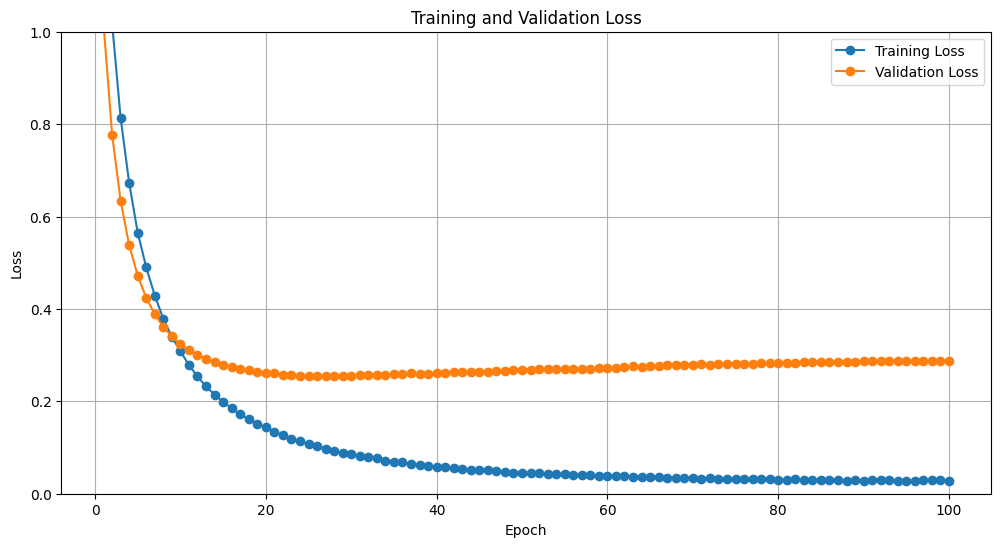

In [24]:
import matplotlib.pyplot as plt

# 손실 값 시각화
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.ylim([0, 1])
plt.grid(True)
plt.show()


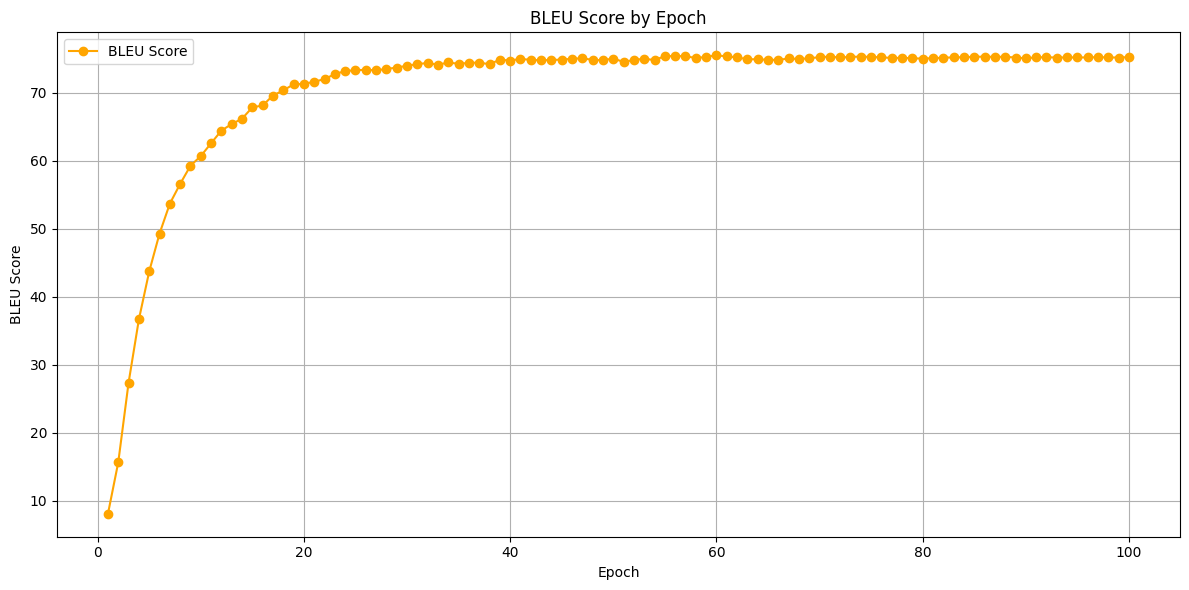

In [25]:
# BLEU 점수 시각화
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(bleu_scores) + 1), bleu_scores, label='BLEU Score', marker='o', color='orange')
plt.xlabel('Epoch')
plt.ylabel('BLEU Score')
plt.title('BLEU Score by Epoch')
plt.legend()
plt.grid(True)

# 전체 시각화 출력
plt.tight_layout()
plt.show()

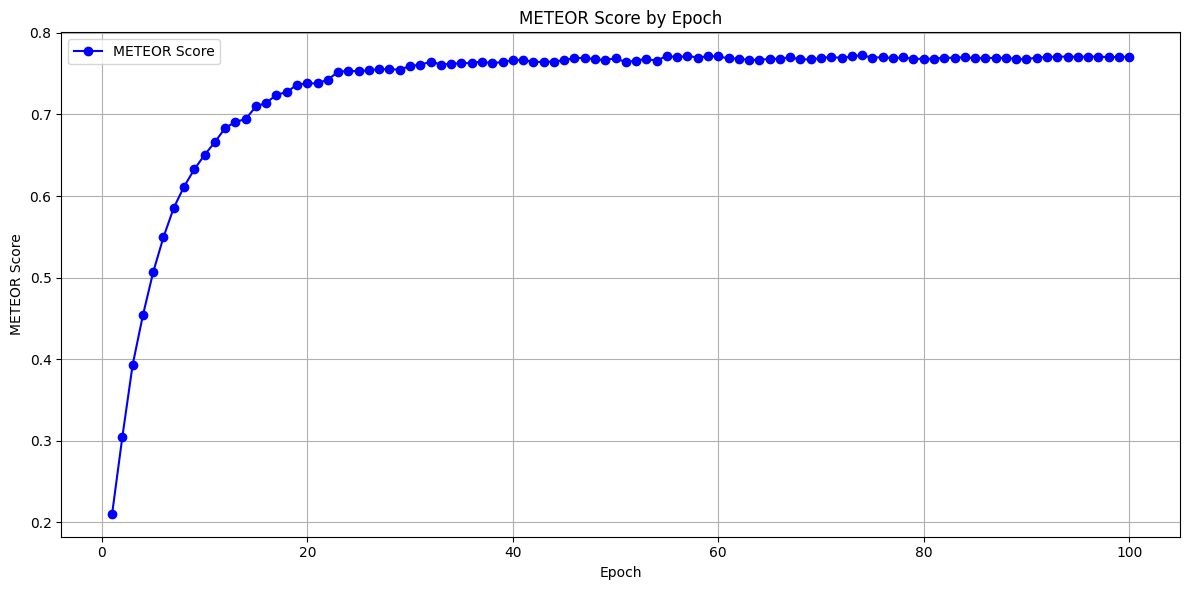

In [26]:
# BLEU 점수 시각화
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(meteor_scores) + 1), meteor_scores, label='METEOR Score', marker='o', color='BLUE')
plt.xlabel('Epoch')
plt.ylabel('METEOR Score')
plt.title('METEOR Score by Epoch')
plt.legend()
plt.grid(True)

# 전체 시각화 출력
plt.tight_layout()
plt.show()

## 5. test

In [27]:
#train_losses
(np.argmin(val_losses)+1, np.argmax(bleu_scores)+1, np.argmax(meteor_scores)+1)
#

(30, 60, 74)

In [29]:
# 체크포인트 로드
checkpoint_path = './checkpoints_0822_small/checkpoint_epoch_60.pt'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

/tmp/ipykernel_49846/220050869.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [30]:
model

T5ForConditionalGeneration(
  (shared): Embedding(50358, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(50358, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

In [68]:
#!pip install sacrebleu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [69]:
#!pip install nltk

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [30]:
import torch
import sacrebleu
from tqdm import tqdm
import nltk
from nltk.translate.meteor_score import meteor_score

# 모델을 GPU로 이동
model = model.to(device)

# 모델을 평가 모드로 설정
model.eval()

# 예측 및 참조 번역 수집
predictions = []
references = []
meteor_scores = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        # 입력 데이터를 GPU로 이동
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # 모델에 데이터 전달
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=256,  # 적절한 max_length 설정
            length_penalty=2.0,  # 번역 길이 조절
            num_beams=4,  # 빔 서치의 수
            early_stopping=True
        )

        # 예측 결과 디코딩
        decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        # 실제 레이블 디코딩
        decoded_labels = []
        for label in labels:
            label_ids = label[label != tokenizer.pad_token_id].tolist()
            if label_ids:
                try:
                    decoded_label = tokenizer.decode(label_ids, skip_special_tokens=True)
                except OverflowError:
                    decoded_label = "[UNK]"  # Unknown token으로 처리
                decoded_labels.append(decoded_label)
            else:
                decoded_labels.append('')  # 빈 문자열로 처리

        # 예측 결과와 참조 번역 수집
        predictions.extend(decoded_preds)
        references.extend(decoded_labels)

        # METEOR 점수 계산 (토큰화된 형태로 변환)
        for pred, ref in zip(decoded_preds, decoded_labels):
            meteor_scores.append(meteor_score([ref.split()], pred.split()))

# BLEU 점수 계산
bleu_score = sacrebleu.corpus_bleu(predictions, [references])

# METEOR 점수 평균 계산
avg_meteor_score = sum(meteor_scores) / len(meteor_scores)

print(f'BLEU score: {bleu_score.score:.4f}')
print(f'METEOR score: {avg_meteor_score:.4f}')


Evaluating: 100%|██████████| 53/53 [00:08<00:00,  6.24it/s]

BLEU score: 73.3492
METEOR score: 0.7687


In [33]:
# 기본
import torch

def generate_translation(model, tokenizer, sentences, max_length=50):
    model.eval()
    translations = []
    for sentence in sentences:
        # 토큰화 및 텐서 변환
        inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding='max_length', max_length=max_length)

        # GPU가 사용 중이면 데이터를 GPU로 이동
        input_ids = inputs['input_ids'].to(model.device)
        attention_mask = inputs['attention_mask'].to(model.device)

        # 모델에 데이터 전달
        output_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_length,
            num_beams=5,  # Beam search 설정
            early_stopping=True
        )

        # 디코딩
        for output in output_ids:
            translation = tokenizer.decode(output, skip_special_tokens=True)
            translations.append(translation)

    return translations

In [39]:
# 테스트 문장
# test_sentences = ["날씨 덥다 화 난다.", "지금 바쁘다 미래 연락."]
test_sentences = ["날씨 덥다 화 난다", "목 마르다 물 마시다", '수영장 가다 놀다', '재미 있다 피곤하다 잠']

translations = generate_translation(model, tokenizer, test_sentences)
print(translations)

['날씨가 너무 더워서 화가 난다', '목이 마르다', '수영장에 가서 놀다', '재미 있어서 졸려']


In [73]:
# 테스트 문장
# test_sentences = ["날씨 덥다 화 난다.", "지금 바쁘다 미래 연락."]
test_sentences = ["어제 일찍 자다"]

translations = generate_translation(model, tokenizer, test_sentences)
print(translations)

['어제는 일찍 일어나서 잤다']


In [74]:
# 앞 문장과 합성해서 뒷 문장 내용 추출

def generate_translation(model, tokenizer, sentences, max_length=50):
    model.eval()
    translations = []

    for i, sentence in enumerate(sentences):
        if i > 0:
            # 이전 번역된 문장을 참조하지 않고 현재 문장만 입력으로 사용
            combined_sentence = sentences[i-1] + " " + sentence
        else:
            combined_sentence = sentence

        # 토큰화 및 텐서 변환
        inputs = tokenizer(combined_sentence, return_tensors='pt', truncation=True, padding='max_length', max_length=max_length)

        # GPU가 사용 중이면 데이터를 GPU로 이동
        input_ids = inputs['input_ids'].to(model.device)
        attention_mask = inputs['attention_mask'].to(model.device)

        # 모델에 데이터 전달
        output_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_length,
            num_beams=5,  # Beam search 설정
            early_stopping=True
        )

        # 디코딩
        translation = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        translations.append(translation)

    return translations

In [75]:
# 테스트 문장
test_sentences = ["날씨 덥다 화 난다", "물 마시다 원하다"]

# 번역 결과 생성
translations = generate_translation(model, tokenizer, test_sentences)
print(translations)

['날씨가 너무 더워서 화가 난다', '날씨가 너무 더워서 물이 마시고 싶어']
